In [2]:
import pandas as pd
df = pd.read_csv('/content/Test matrix for comparing TEG process simulations rev1.csv')
print(df.loc[1])

Case                            1
dry feed gas                 30.4
dry feed gas.1               51.2
dry feed gas.2                6.8
lean TEG cooler              43.6
lean TEG to absorber       6795.4
Rich TEG HP flash valve       4.9
rich TEG preheater           37.5
rich TEG heater HP             62
LP rich glycol heater         139
LP rich glycol heater.1      1.24
TEG regeneration column     205.6
stripGas                    61.88
stripGas.1                  205.6
stripGas.2                   1.24
hot lean TEG pump              20
lean TEG cooler.1           44.85
lean TEG HP pump             51.2
Unnamed: 18                   NaN
Name: 1, dtype: object


In [3]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim
from neqsim.process import openprocess
import urllib
import time
# Importing the TEG process from file
!wget https://github.com/equinor/neqsimprocess/raw/master/lib/TEGprocess.neqsim

In [4]:
# importing the process from the stored file
# See: https://github.com/equinor/neqsimprocess/blob/master/src/neqsimprocess/glycol/TEGprocess.java
# See Figure 1 for process flow diagram
TEGprocess = openprocess('TEGprocess.neqsim')

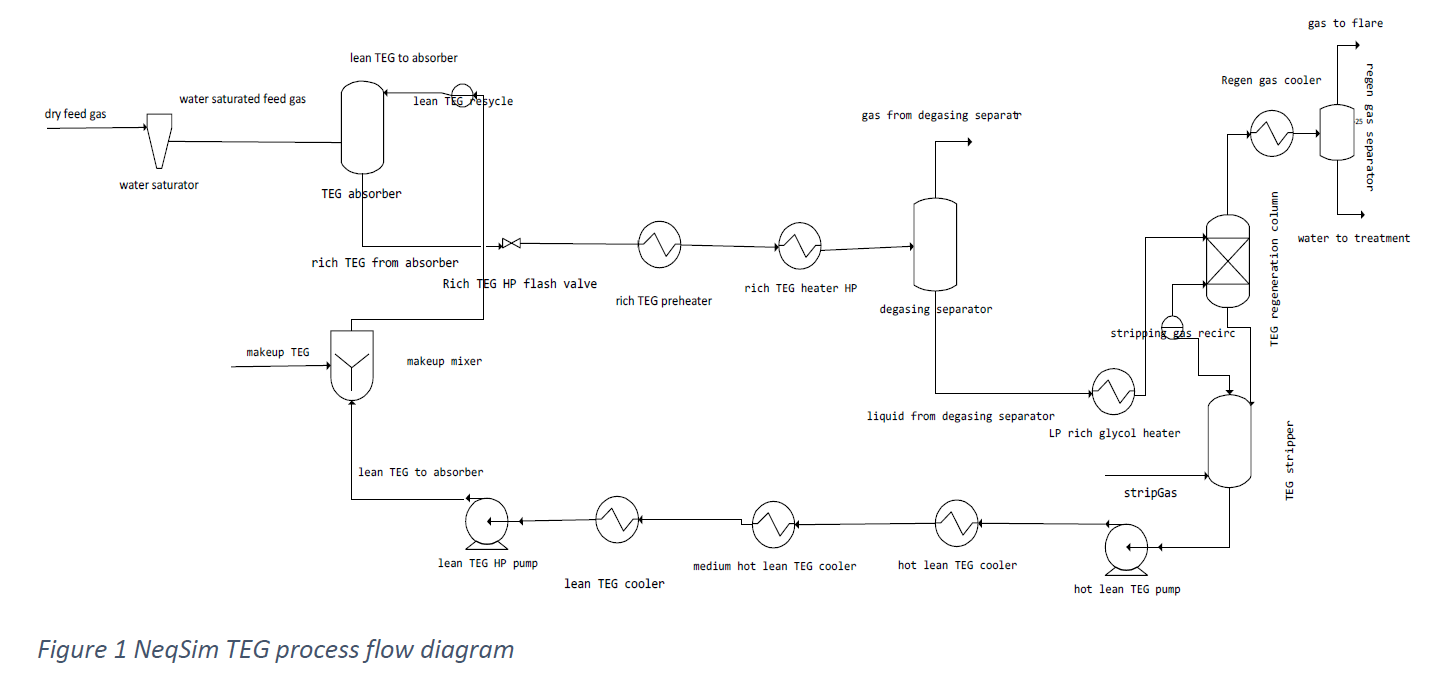

In [5]:
# Set input parameters
caseNumber = 8

TEGprocess.getUnit("dry feed gas").setFlowRate(float(df.loc[caseNumber]['dry feed gas.2']), 'MSm3/day')
TEGprocess.getUnit("dry feed gas").setTemperature(float(df.loc[caseNumber]['dry feed gas']), 'C')
TEGprocess.getUnit("dry feed gas").setPressure(float(df.loc[caseNumber]['dry feed gas.1']), "bara")
TEGprocess.getUnit("lean TEG to absorber").setFlowRate(float(df.loc[caseNumber]['lean TEG to absorber']), "kg/hr")
TEGprocess.getUnit("rich TEG preheater").setOutTemperature(273.15 + 35.5)#float(df.loc[caseNumber]['rich TEG preheater']))
TEGprocess.getUnit("TEG absorber").setNumberOfStages(5)
TEGprocess.getUnit("TEG absorber").setStageEfficiency(0.485)
TEGprocess.getUnit("Rich TEG HP flash valve").setOutletPressure(float(df.loc[caseNumber]['Rich TEG HP flash valve']))
TEGprocess.getUnit("rich TEG heater HP").setOutTemperature(273.15 + float(df.loc[caseNumber]['rich TEG heater HP']))
TEGprocess.getUnit("LP rich glycol heater").setOutTemperature(273.15 + float(df.loc[caseNumber]['LP rich glycol heater']))
TEGprocess.getUnit("LP rich glycol heater").setOutPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']))
TEGprocess.getUnit("TEG regeneration column").getReboiler().setOutTemperature(273.15 + float(df.loc[caseNumber]['TEG regeneration column']))
TEGprocess.getUnit("TEG regeneration column").setBottomPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']))
TEGprocess.getUnit("TEG regeneration column").setTopPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']))
TEGprocess.getUnit("regen gas cooler").setOutTemperature(273.15+37.5)
TEGprocess.getUnit("stripGas").setPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']), "bara")
TEGprocess.getUnit("stripGas").setFlowRate(float(df.loc[caseNumber]['stripGas']), "kg/hr")
TEGprocess.getUnit("stripGas").setTemperature(float(df.loc[caseNumber]['stripGas.1']), 'C')
TEGprocess.getUnit("hot lean TEG pump").setOutletPressure(float(df.loc[caseNumber]['hot lean TEG pump']))
TEGprocess.getUnit("hot lean TEG pump").setIsentropicEfficiency(0.75)
TEGprocess.getUnit("lean TEG cooler").setOutTemperature(float(df.loc[caseNumber]['lean TEG cooler.1'])+273.15)                          
TEGprocess.getUnit("lean TEG HP pump").setOutletPressure(float(df.loc[caseNumber]['lean TEG HP pump']))                        
TEGprocess.getUnit("lean TEG HP pump").setIsentropicEfficiency(0.75)

In [6]:
#Run the process calculations
tic = time.perf_counter()
TEGprocess.run()
toc = time.perf_counter()
print(f"Simulation run in {toc - tic:0.4f} seconds")

Simulation run in 54.9332 seconds


In [7]:
#Read results
wetGasRatekghr = TEGprocess.getUnit("water saturated feed gas").getFlowRate("kg/hr")
waterInWetGasppm = TEGprocess.getUnit("water saturated feed gas").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInDryGasppm = TEGprocess.getUnit("dry gas from absorber").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInWetGaskgMSm3 = waterInWetGasppm*0.01802*101325.0/(8.314*288.15)
waterInWetGaskghr = waterInWetGaskgMSm3*TEGprocess.getUnit("dry feed gas").getFlowRate("Sm3/day")/1.0e6/24.0
waterInDryGaskgMSm3 = waterInDryGasppm*0.01802*101325.0/(8.314*288.15)
wtLeanTEGFromReboiler = TEGprocess.getUnit("TEG regeneration column").getLiquidOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtLeanTEGFromStripper = TEGprocess.getUnit("TEG stripper").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtRichTEGFromAbsorber = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
richTEGtemperature = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getTemperature("C")
waterInRichTEGkghr = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water")*TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getFlowRate("kg/hr")
TEGcirculationratelitreperkg = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")*wtLeanTEGFromStripper/100/waterInWetGaskghr
richTEGtemperatureAfterDepres = TEGprocess.getUnit("Rich TEG HP flash valve").getOutStream().getFluid().getTemperature("C")
RichTEGwtprbinary = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")/(TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")+TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water"))*100
reboilerdutykW = TEGprocess.getUnit("TEG regeneration column").getReboiler().getDuty()/1.0e3
condenserdutykW = TEGprocess.getUnit("TEG regeneration column").getCondenser().getDuty()/1.0e3
glycolheater2dutykW = TEGprocess.getUnit("rich TEG heater HP").getDuty()/1.0e3
condensertemperature= TEGprocess.getUnit("TEG regeneration column").getCondenser().getTemperature()-273.15
reboilertemperature= TEGprocess.getUnit("TEG regeneration column").getReboiler().getTemperature()-273.15
TEGmakeupkghr = TEGprocess.getUnit("makeup calculator").getOutputVariable().getFluid().getFlowRate("kg/hr")
TEGmakeupkgMSm3 = TEGmakeupkghr/TEGprocess.getUnit("dry feed gas").getFlowRate("Sm3/day")/1.0e6*24
leanTEGflow = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")
richTEGflow = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFlowRate("kg/hr")
pump1DutykW = TEGprocess.getUnit("hot lean TEG pump").getEnergy()/1.0e3
pump2DutykW = TEGprocess.getUnit("lean TEG HP pump").getEnergy()/1.0e3
flashGasRate = TEGprocess.getUnit("gas from degasing separator").getFlowRate("kg/hr")
gasToFLareRatekghr = TEGprocess.getUnit("gas to flare").getFlowRate("kg/hr")
stripGasRatekghr = TEGprocess.getUnit("stripGas").getFlowRate("kg/hr")
waterToTreatment = TEGprocess.getUnit("water to treatment").getFlowRate("kg/hr")
TEGinwatertoTreatmentwtprecent = TEGprocess.getUnit("water to treatment").getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
flowFromReboiler = TEGprocess.getUnit("TEG regeneration column").getReboiler().getLiquidOutStream().getFlowRate("kg/hr")
richTEGpreheaterDutykW = TEGprocess.getUnit("rich TEG preheater").getDuty()/1000.0

In [8]:
# Print results
print('Wet gas rate ', wetGasRatekghr, ' kg/hr')
print('Water in wet gas ', waterInWetGasppm, ' ppm (mol)')
print('Water in dry gas ', waterInDryGasppm, ' ppm (mol)')
print('Water in wet gas ', waterInWetGasppm, ' kg/MSm3')
print('Water in dry gas ', waterInDryGasppm, ' kg/MSm3')
print('wt% TEG from absorber' , wtRichTEGFromAbsorber, ' wt%')
print('wt% TEG from reboiler ', wtLeanTEGFromReboiler, ' wt%')
print('wt% TEG from stripper ', wtLeanTEGFromStripper, ' wt%')
print('Reboiler duty ', reboilerdutykW, ' kW')
print('Condenser duty ', condenserdutykW, ' kW')
print('rich TEG preheater duty ', richTEGpreheaterDutykW, ' kW')
print('rich TEG heater HP duty', glycolheater2dutykW, ' kW')
print('temperature from condenser ', condensertemperature, ' C')
print('temperature from reboiler ', reboilertemperature, ' C')
print('TEG makeup ', TEGmakeupkghr, ' kg/hr')
print('lean TEG flow ', leanTEGflow, ' kg/hr')
print('rich TEG flow ', richTEGflow, ' kg/hr')
print('hot lean TEG pump duty ', pump1DutykW, ' kW')
print('lean TEG HP pump duty ', pump2DutykW, ' kW')
print('gas from degasing separator ', flashGasRate, ' kg/hr')
print('gas to flare ', gasToFLareRatekghr, ' kg/hr')

Wet gas rate  388972.9340275575  kg/hr
Water in wet gas  1012.2864466374118  ppm (mol)
Water in dry gas  26.783219384674382  ppm (mol)
Water in wet gas  1012.2864466374118  kg/MSm3
Water in dry gas  26.783219384674382  kg/MSm3
wt% TEG from absorber 93.57813995994503  wt%
wt% TEG from reboiler  98.98714825687716  wt%
wt% TEG from stripper  99.80947758365936  wt%
Reboiler duty  541.5988033799268  kW
Condenser duty  -13.48305384691619  kW
rich TEG preheater duty  13.483053802476265  kW
rich TEG heater HP duty 128.96368080034782  kW
temperature from condenser  110.56667187139749  C
temperature from reboiler  205.60000000000002  C
TEG makeup  1.053983924750877  kg/hr
lean TEG flow  6795.400000000001  kg/hr
rich TEG flow  7247.66966681547  kg/hr
hot lean TEG pump duty  4.836211284049554  kW
lean TEG HP pump duty  7.445484059318434  kW
gas from degasing separator  49.96942486804845  kg/hr
gas to flare  116.67514915200037  kg/hr


In [ ]:
#saving process status to file
TEGprocess.save('TEGprocess2.neqsim')

In [28]:
df2 = pd.DataFrame(columns=['Wet gas rate[kg/hr]','Water in wet gas[ppm (mol)]','Water in dry gas[ppm (mol)]','Water in wet gas[kg/MSm3]'], index=df.index)

In [29]:
df2.loc[caseNumber]= [wetGasRatekghr,waterInWetGasppm,waterInDryGasppm,waterInWetGasppm]

In [30]:
df2

,Wet gas rate[kg/hr],Water in wet gas[ppm (mol)],Water in dry gas[ppm (mol)],Water in wet gas[kg/MSm3]
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,388973,1012.29,26.7832,1012.29
9,NaN,NaN,NaN,NaN


In [34]:
def calcCase(caseNumber):
  TEGprocess.getUnit("dry feed gas").setFlowRate(float(df.loc[caseNumber]['dry feed gas.2']), 'MSm3/day')
  TEGprocess.getUnit("dry feed gas").setTemperature(float(df.loc[caseNumber]['dry feed gas']), 'C')
  TEGprocess.getUnit("dry feed gas").setPressure(float(df.loc[caseNumber]['dry feed gas.1']), "bara")
  TEGprocess.getUnit("lean TEG to absorber").setFlowRate(float(df.loc[caseNumber]['lean TEG to absorber']), "kg/hr")
  TEGprocess.getUnit("rich TEG preheater").setOutTemperature(273.15 + 35.5)#float(df.loc[caseNumber]['rich TEG preheater']))
  TEGprocess.getUnit("TEG absorber").setNumberOfStages(5)
  TEGprocess.getUnit("TEG absorber").setStageEfficiency(0.485)
  TEGprocess.getUnit("Rich TEG HP flash valve").setOutletPressure(float(df.loc[caseNumber]['Rich TEG HP flash valve']))
  TEGprocess.getUnit("rich TEG heater HP").setOutTemperature(273.15 + float(df.loc[caseNumber]['rich TEG heater HP']))
  TEGprocess.getUnit("LP rich glycol heater").setOutTemperature(273.15 + float(df.loc[caseNumber]['LP rich glycol heater']))
  TEGprocess.getUnit("LP rich glycol heater").setOutPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']))
  TEGprocess.getUnit("TEG regeneration column").getReboiler().setOutTemperature(273.15 + float(df.loc[caseNumber]['TEG regeneration column']))
  TEGprocess.getUnit("TEG regeneration column").setBottomPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']))
  TEGprocess.getUnit("TEG regeneration column").setTopPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']))
  TEGprocess.getUnit("regen gas cooler").setOutTemperature(273.15+37.5)
  TEGprocess.getUnit("stripGas").setPressure(float(df.loc[caseNumber]['LP rich glycol heater.1']), "bara")
  TEGprocess.getUnit("stripGas").setFlowRate(float(df.loc[caseNumber]['stripGas']), "kg/hr")
  TEGprocess.getUnit("stripGas").setTemperature(float(df.loc[caseNumber]['stripGas.1']), 'C')
  TEGprocess.getUnit("hot lean TEG pump").setOutletPressure(float(df.loc[caseNumber]['hot lean TEG pump']))
  TEGprocess.getUnit("hot lean TEG pump").setIsentropicEfficiency(0.75)
  TEGprocess.getUnit("lean TEG cooler").setOutTemperature(float(df.loc[caseNumber]['lean TEG cooler.1'])+273.15)                          
  TEGprocess.getUnit("lean TEG HP pump").setOutletPressure(float(df.loc[caseNumber]['lean TEG HP pump']))                        
  TEGprocess.getUnit("lean TEG HP pump").setIsentropicEfficiency(0.75)
  tic = time.perf_counter()
  TEGprocess.run()
  toc = time.perf_counter()
  print(f"Simulation run in {toc - tic:0.4f} seconds")
  return TEGprocess
  #TEGprocess.save('TEGprocess2.neqsim')


In [37]:
def reportCase(caseNumber):
  wetGasRatekghr = TEGprocess.getUnit("water saturated feed gas").getFlowRate("kg/hr")
  waterInWetGasppm = TEGprocess.getUnit("water saturated feed gas").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
  waterInDryGasppm = TEGprocess.getUnit("dry gas from absorber").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
  waterInWetGaskgMSm3 = waterInWetGasppm*0.01802*101325.0/(8.314*288.15)  
  #df2.loc[caseNumber]= [wetGasRatekghr,waterInWetGasppm,waterInDryGasppm,waterInWetGasppm]
  return [wetGasRatekghr,waterInWetGasppm,waterInDryGasppm,waterInWetGasppm]

In [43]:
df2 = pd.DataFrame(columns=['Wet gas rate[kg/hr]','Water in wet gas[ppm (mol)]','Water in dry gas[ppm (mol)]','Water in wet gas[kg/MSm3]'], index=df.index)


for caseNumber in [8,9,10]:
  simCase8 = calcCase(caseNumber)
  results = reportCase(caseNumber)
  df2.loc[caseNumber]= results

Simulation run in 8.1619 seconds
Simulation run in 56.6728 seconds
Simulation run in 53.9929 seconds


In [44]:
df2

,Wet gas rate[kg/hr],Water in wet gas[ppm (mol)],Water in dry gas[ppm (mol)],Water in wet gas[kg/MSm3]
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,388973,1012.29,26.784,1012.29
9,388973,1012.29,27.4116,1012.29
